In [7]:
import pandas as pd
import numpy as np

# Local Outlier Factor (LOF)
In order to find the best parameters for our Local Outlier Factor algorithm, we will create a pipeline that will use a grid search and stratified k-fold cross-validation to ensure the best parameters and consistent results. Additionally, a search for a good threshold 
value for predicting labels will be searched for based on precision.
- Precision Equation:

precision = true positives / (true positives + false positives)




In [15]:
# Imports Local Outlier Factor code
%run Pipeline_Code.ipynb

In [16]:
import math
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from numpy import random


# tuning is a function that splits the dataset into 4 folds. 3 of the folds are used for training and 1 of the folds is used for testing
# n times if n is the number of parameters. 
# parameters: learner - learner string like local_outlier_factor, parameters - a dictionary with the appropriate hyperparameters to tune for, data - feature values of dataset, labels - label values of dataset
# return: list of tuples containing fold, train data results, and test data results
def tuning(learner, parameters, features, labels):
    res = []
    skf = StratifiedKFold(n_splits=4)
    splits = skf.split(X=features, y=labels)
    
    for i, (train_index, test_index) in enumerate(splits):
        trainFeatures = [features[index] for index in train_index]
        trainLabels = [labels[index] for index in train_index]
        
        testFeatures = [features[index] for index in test_index]
        testLabels = [labels[index] for index in test_index]
        
        foldRes = []
        
        # Will find the best parameters and threshold value on train set and then test on the test set
        if learner == "local_outlier_factor":
            for distance in parameters["metric"]:
                for k in parameters["n_neighbors"]:
                    lof = Local_Outlier_Factor(k, distance, len(features))
                    lof.createOutlierFactor(trainFeatures, 10)
                    lof.findThreshold(trainLabels)
                    predictedTrainLabels = lof.predict(trainFeatures, False, 10)
                    trainPrecision = lof.matrixScores(lof.confusionMatrix(trainLabels, predictedTrainLabels), "precision")
                    predictedTestLabels = lof.predict(testFeatures, True, 10)
                    testPrecision = lof.matrixScores(lof.confusionMatrix(testLabels, predictedTestLabels), "precision")
                    foldRes.append((i, trainPrecision, testPrecision, distance, k))
            res.append(max(foldRes, key = lambda x: x[2]))
    return res
   

    # runPipeline loads specified dataset in and passes the dataset into another function which will run ML classifiers on the dataset
    # return: None, prints out results from classifiers which are run through k-fold cross-validation and hyperparameter tuning
def pipeline(dataSetName, classifier):
    if dataSetName == "credit_card":
        #file path to credit card csv file
        file_path = os.path.join(os.path.expanduser("~"), "Desktop", "archive(2)", "creditcard.csv")
        df = pd.read_csv(file_path) #read csv file as pandas object
        
        #Randomly gets 80000 examples out of the 284807 available examples
        randomIndices = random.randint(284807, size=(80000))
        data = df.take(randomIndices)

        data = np.array(data)
        
        fraud_instances = []
        for i in range(len(data)):
            if data[i][-1] == 1:
                fraud_instances.append(i)
        
        #prints out the number of fraud instances so we can ensure enough positive examples are in the dataset
        print("Number of positive examples: ", len(fraud_instances))
        
        # Gets features
        features = np.array([arr[:-1] for arr in data])
        
        #Gets labels
        labels = np.array(df["Class"][randomIndices])
    else: 
        print("Invalid data set, use one of the following data sets:")
        return

    # Local Outlier Factor Classifier
    if classifier == "local_outlier_factor":
        parameters = {"metric":["euclidean", "manhattan"], "n_neighbors": [5, 10, 25]}
        results = tuning("local_outlier_factor", parameters, features, labels)
        print("Local Outlier Factor Test Results:")
        print("--------------")
        print("Fold, Training Set Precision, Testing Set Precision, distance, k")
        for fold in range(3):
            print(fold, results[fold][1], results[fold][2], results[fold][3], results[fold][4])
        


In [17]:
pipeline("credit_card", "local_outlier_factor")

Number of positive examples:  137
Local Outlier Factor Test Results:
--------------
Fold, Training Set Precision, Testing Set Precision, distance, k
0 0 0.03225806451612903 manhattan 5
1 0.0017119838872104733 0.0017178658043654 euclidean 5
2 0 0 euclidean 5


In [29]:
# tuning is a function that splits the dataset into 4 folds and returns the predicted labels and actual labels for both the training and testing sets
# n times if n is the number of parameters. 
# parameters: data - feature values of dataset, labels - label values of dataset
# return: list of tuples containing fold, train data predicted and actual labels, and test data predicted and actual labels
def tuning2(features, labels):
    res = []
    skf = StratifiedKFold(n_splits=4)
    splits = skf.split(X=features, y=labels)
    
    for i, (train_index, test_index) in enumerate(splits):
        trainFeatures = [features[index] for index in train_index]
        trainLabels = [labels[index] for index in train_index]
        
        testFeatures = [features[index] for index in test_index]
        testLabels = [labels[index] for index in test_index]
        
        # Will return the predicted and actual labels for both training and testing sets
        lof = Local_Outlier_Factor(5, "euclidean", len(features))
        lof.createOutlierFactor(trainFeatures, 10)
        lof.findThreshold(trainLabels)
        predictedTrainLabels = lof.predict(trainFeatures, False, 10)
        predictedTestLabels = lof.predict(testFeatures, True, 10)

        res.append([i, (predictedTrainLabels, trainLabels), (predictedTestLabels, testLabels)])
    return res
   

    # runPipeline loads specified dataset in and passes the dataset into another function which will run ML classifiers on the dataset
    # return: None, prints out results from classifiers which are run through k-fold cross-validation and hyperparameter tuning
def pipeline2(dataSetName, classifier):
    if dataSetName == "credit_card":
        #file path to credit card csv file
        file_path = os.path.join(os.path.expanduser("~"), "Desktop", "archive(2)", "creditcard.csv")
        df = pd.read_csv(file_path) #read csv file as pandas object
        
        #Randomly gets 80000 examples out of the 284807 available examples
        randomIndices = random.randint(284807, size=(80000))
        data = df.take(randomIndices)

        data = np.array(data)
        
        fraud_instances = []
        for i in range(len(data)):
            if data[i][-1] == 1:
                fraud_instances.append(i)
        
        #prints out the number of fraud instances so we can ensure enough positive examples are in the dataset
        print("Number of positive examples: ", len(fraud_instances))
        
        # Gets features
        features = np.array([arr[:-1] for arr in data])
        
        #Gets labels
        labels = np.array(df["Class"][randomIndices])
    else: 
        print("Invalid data set, use one of the following data sets:")
        return

    # Local Outlier Factor Classifier
    if classifier == "local_outlier_factor":
        results = tuning2(features, labels)
        return results


In [30]:
results = pipeline2("credit_card", "local_outlier_factor")

Number of positive examples:  145


In [33]:
print("Mahalanobis Distance Test Results:")
print("--------------")
print("Fold, Training Set Matrix Data, Testing Matrix Data")
for fold in range(4):
    print(fold+1)
    print("Training")
    print(matrixScoresMD(confusionMatrixMD(results[fold][1][1], results[fold][1][0]), "precision"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][1][1], results[fold][1][0]), "recall"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][1][1], results[fold][1][0]), "f1score"))
    
    print("Testing")
    print(matrixScoresMD(confusionMatrixMD(results[fold][2][1], results[fold][2][0]), "precision"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][2][1], results[fold][2][0]), "recall"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][2][1], results[fold][2][0]), "f1score"))

Mahalanobis Distance Test Results:
--------------
Fold, Training Set Matrix Data, Testing Matrix Data
1
Training
0
0
0
Testing
0
0
0
2
Training
0
0
0
Testing
0
0
0
3
Training
0
0
0
Testing
0
0
0
4
Training
0
0
0
Testing
0
0
0


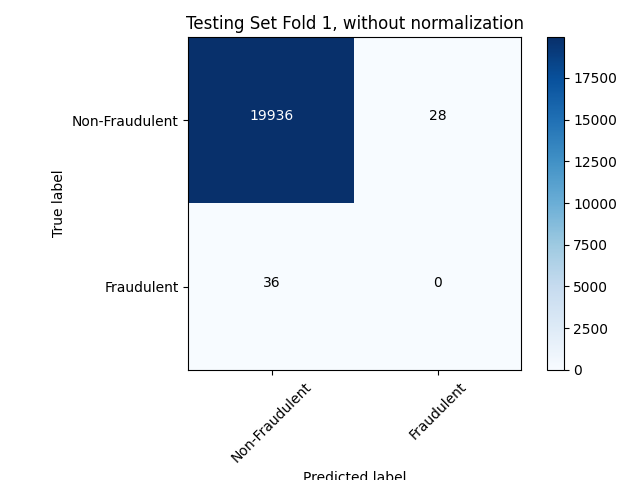

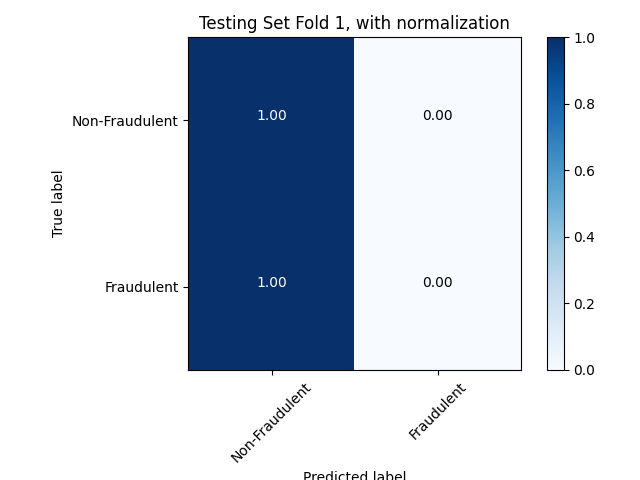

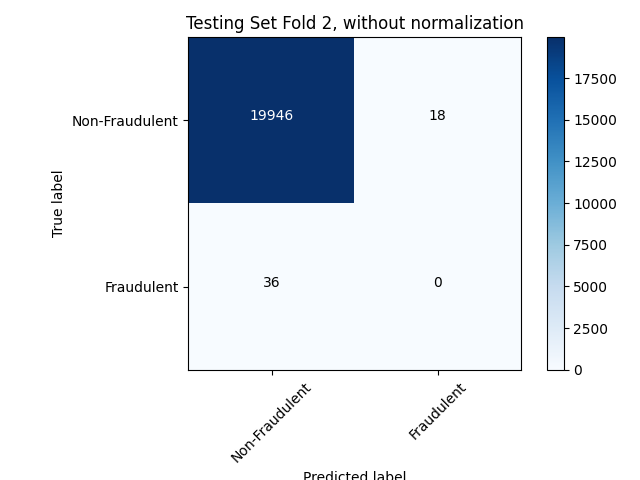

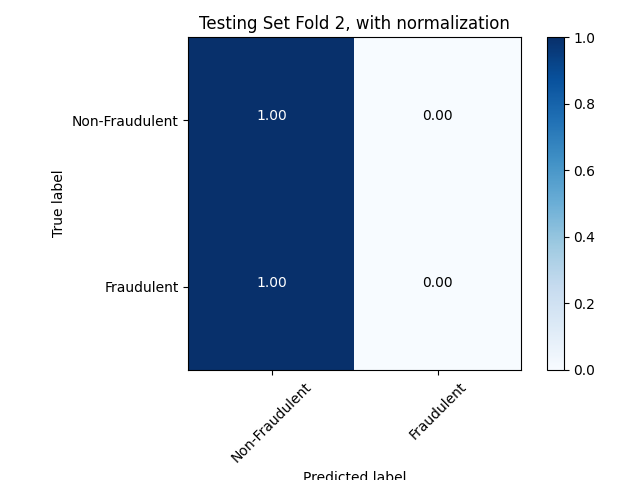

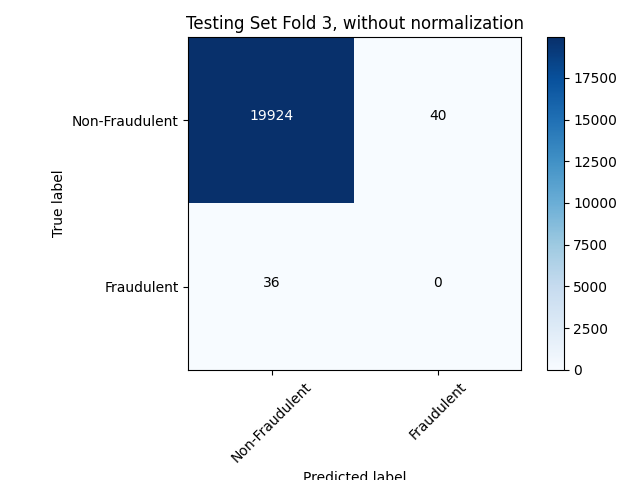

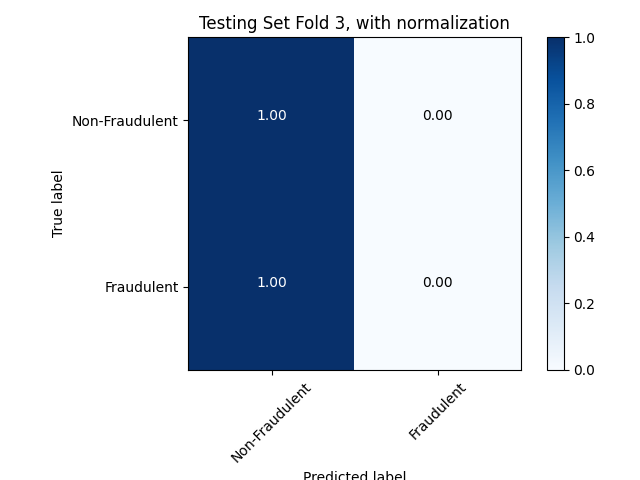

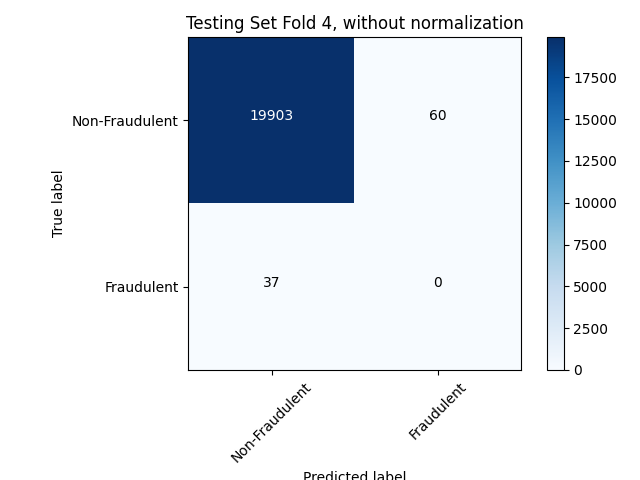

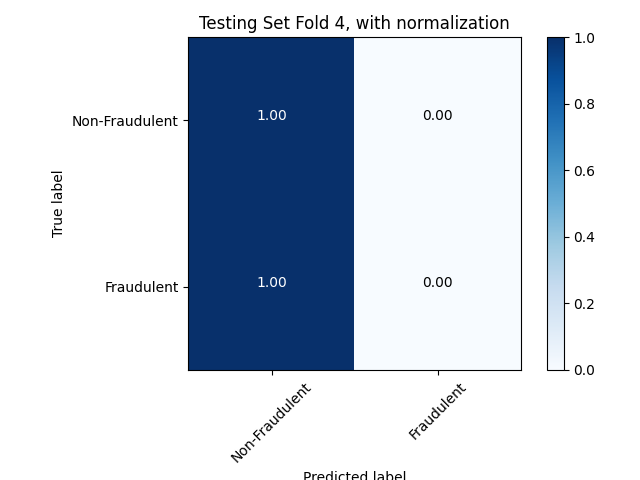

In [32]:
import matplotlib.pyplot as plt
import itertools
%matplotlib widget
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

for i in range(len(results)):
    cm = confusion_matrix(y_true=results[i][2][1], y_pred=results[i][2][0])
    plt.figure()
    title1 = "Testing Set Fold " + str(i+1) + ", without normalization"
    plot_confusion_matrix(cm, ["Non-Fraudulent", "Fraudulent"], normalize=False, title=title1)
    title2 = "Testing Set Fold " + str(i+1) + ", with normalization"
    plt.figure()
    plot_confusion_matrix(cm, ["Non-Fraudulent", "Fraudulent"], normalize=True, title=title2)

In [35]:
#file path to credit card csv file
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "archive(2)", "creditcard.csv")
df = pd.read_csv(file_path) #read csv file as pandas object

#Randomly gets 80000 examples out of the 284807 available examples
randomIndices = random.randint(284807, size=(20000))
data = df.take(randomIndices)

data = np.array(data)

fraud_instances = []
for i in range(len(data)):
    if data[i][-1] == 1:
        fraud_instances.append(i)

#prints out the number of fraud instances so we can ensure enough positive examples are in the dataset
print("Number of positive examples: ", len(fraud_instances))

# Gets features
features = np.array([arr[:-1] for arr in data])

#Gets labels
labels = np.array(df["Class"][randomIndices])

myLOF = Local_Outlier_Factor(5, "euclidean", len(features))
myLOF.createOutlierFactor(features, 10)
print(np.mean(myLOF.lofScores))
print(np.mean(myLOF.lofScores[fraud_instances]))

Number of positive examples:  37
1.1748948429591322


TypeError: list indices must be integers or slices, not list

In [37]:
total = 0
for fraud in fraud_instances:
    total += myLOF.lofScores[fraud\textbf{Mahalanobis Distance}]
print(total/len(fraud_instances))

1.211381312960109
